## Finetune Llama-2-7b on a Google colab

Welcome to this Google Colab notebook that shows how to fine-tune the recent Llama-2-7b model on a single Google colab and turn it into a chatbot

We will leverage PEFT library from Hugging Face ecosystem, as well as QLoRA for more memory efficient finetuning

## Setup

Run the cells below to setup and install the required libraries. For our experiment we will need `accelerate`, `peft`, `transformers`, `datasets` and TRL to leverage the recent [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer). We will use `bitsandbytes` to [quantize the base model into 4bit](https://huggingface.co/blog/4bit-transformers-bitsandbytes). We will also install `einops` as it is a requirement to load Falcon models.

In [2]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4

## Dataset



In [1]:
from datasets import load_dataset


dataset_name = '404NotF0und/MtG-json-to-ForgeScribe'
dataset = load_dataset(dataset_name, split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Loading the model

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "TinyPixel/Llama-2-7B-bf16-sharded"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

Let's also load the tokenizer below

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [4]:
from peft import LoraConfig, get_peft_model

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

## Loading the trainer

Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [5]:
from transformers import TrainingArguments

output_dir = "./results"
logging_dir = "./logs"  # Add a logging directory
per_device_train_batch_size = 1
gradient_accumulation_steps = 1
optim = "paged_adamw_32bit"
save_steps = 1000
logging_steps = 100
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 5000
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    logging_dir=logging_dir,  # Add the logging directory to the TrainingArguments
    report_to="tensorboard",  # Report logs to TensorBoard
)

Then finally pass everthing to the trainer

In [6]:
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


We will also pre-process the model by upcasting the layer norms in float 32 for more stable training

In [7]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Train the model

Now let's train the model! Simply call `trainer.train()`

In [8]:
trainer.train()

Step,Training Loss
100,0.916000
200,0.559400
300,0.518900
400,0.429800
500,0.411400
600,0.382400
700,0.428800
800,0.387500
900,0.350400
1000,0.364100


TrainOutput(global_step=5000, training_loss=0.34094589881896975, metrics={'train_runtime': 7190.3002, 'train_samples_per_second': 0.695, 'train_steps_per_second': 0.695, 'total_flos': 6.843445438464e+16, 'train_loss': 0.34094589881896975, 'epoch': 0.26})

In [9]:
!pip install tensorboard

In [10]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def print_logs(log_dir):
    event_files = [file for file in os.listdir(log_dir) if file.startswith("events.out.tfevents")]

    if not event_files:
        print("No event files found.")
        return

    event_file = os.path.join(log_dir, event_files[0])
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()

    # Print scalar events
    for tag in sorted(event_acc.Tags()["scalars"]):
        event_list = event_acc.Scalars(tag)
        print(f"Tag: {tag}")
        for event in event_list:
            print(f"Step: {event.step}, Value: {event.value}")
        print()

print_logs(logging_dir)

In [11]:
!pip install matplotlib

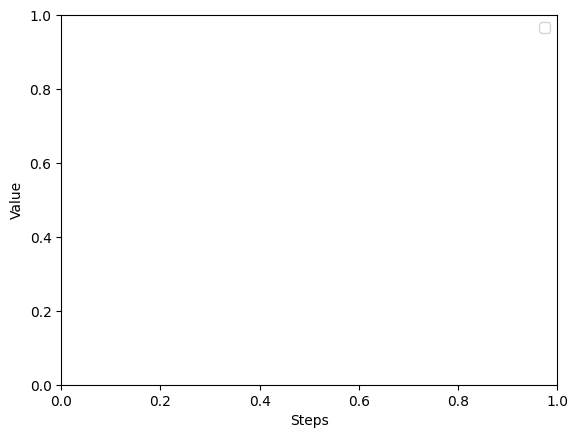

In [12]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_logs(log_dir):
    event_files = [file for file in os.listdir(log_dir) if file.startswith("events.out.tfevents")]

    if not event_files:
        print("No event files found.")
        return

    event_file = os.path.join(log_dir, event_files[0])
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()

    # Plot scalar events
    for tag in sorted(event_acc.Tags()["scalars"]):
        event_list = event_acc.Scalars(tag)
        steps = [event.step for event in event_list]
        values = [event.value for event in event_list]

        plt.plot(steps, values, label=tag)

    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

plot_logs(logging_dir)

In [13]:
# Step 1: Load the test and validation splits of the dataset
test_dataset = load_dataset(dataset_name, split="test")
val_dataset = load_dataset(dataset_name, split="validation")


print(test_dataset[0])
print(val_dataset[0])

{'instruction': 'Create the Forge script for this magic card', 'input': '{"name": "Pharika\'s Chosen", "mana_cost": "{B}", "type_line": "Creature \\u2014 Snake", "oracle_text": "Deathtouch (Any amount of damage this deals to a creature is enough to destroy it.)", "power": "1", "toughness": "1"}', 'output': "Name:Pharika's Chosen\\nManaCost:B\\nTypes:Creature Snake\\nPT:1/1\\nK:Deathtouch\\nOracle:Deathtouch (Any amount of damage this deals to a creature is enough to destroy it.)", 'text': 'Below is an instruction that describes a task then the input and response.\n### Instruction: Create the Forge script for this magic card\n### Input: {"name": "Pharika\'s Chosen", "mana_cost": "{B}", "type_line": "Creature \\u2014 Snake", "oracle_text": "Deathtouch (Any amount of damage this deals to a creature is enough to destroy it.)", "power": "1", "toughness": "1"}\n### Response: Name:Pharika\'s Chosen\\nManaCost:B\\nTypes:Creature Snake\\nPT:1/1\\nK:Deathtouch\\nOracle:Deathtouch (Any amount of 

In [14]:

# Step 2: Write a function to generate predictions for the given dataset split
def generate_predictions(model, tokenizer, dataset, max_length=512, batch_size=8, num_samples=None):
    if num_samples is not None:
        dataset = dataset.select(range(num_samples))

    dataset = dataset.to_dict()  # Convert the dataset to a list of dictionaries

    predictions = []
    for i in range(0, len(dataset['input']), batch_size):
        batch = {"input": dataset["input"][i:i + batch_size], "output": dataset["output"][i:i + batch_size]}
        input_texts = batch["input"]
        input_ids = tokenizer(input_texts, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True).input_ids
        generated_outputs = model.generate(input_ids, max_length=max_length)
        generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in generated_outputs]
        predictions.extend(generated_texts)
    return predictions


In [15]:

# Step 3: Write a function to calculate the evaluation metric based on the model's predictions and the ground truth labels
from sklearn.metrics import accuracy_score

def calculate_accuracy(predictions, ground_truths):
    correct_predictions = sum([1 for pred, gt in zip(predictions, ground_truths) if pred == gt])
    accuracy = correct_predictions / len(predictions)
    return accuracy


In [16]:
# Step 4: Plot the performance metrics for the test and validation splits
def evaluate_and_plot(model, tokenizer, test_dataset, val_dataset, num_samples=None):
    test_predictions = generate_predictions(model, tokenizer, test_dataset, num_samples=num_samples)
    val_predictions = generate_predictions(model, tokenizer, val_dataset, num_samples=num_samples)

    test_accuracy = calculate_accuracy(test_predictions, test_dataset["output"][:num_samples])
    val_accuracy = calculate_accuracy(val_predictions, val_dataset["output"][:num_samples])

    plt.bar(["Test", "Validation"], [test_accuracy, val_accuracy])
    plt.xlabel("Dataset Split")
    plt.ylabel("Accuracy")
    plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 512, but `max_length` is set to 512. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1413: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


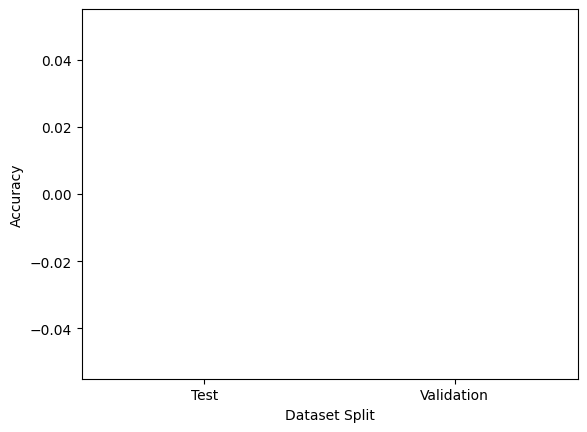

In [17]:
evaluate_and_plot(model, tokenizer, test_dataset, val_dataset, num_samples=100)  # Limit the number of samples processed for evaluation

In [18]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("outputs")

In [19]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [ ]:
dataset['text']

In [28]:
text = "Create the Forge script for this magic card \{\"name\": \"Pharika\'s Chosen\", \"mana_cost\": \"{B}\", \"type_line\": \"Creature \u2014 Snake\", \"oracle_text\": \"Deathtouch (Any amount of damage this deals to a creature is enough to destroy it.)\", \"power\": \"1\", \"toughness\": \"1\"}"
device = "cuda:0"

inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Create the Forge script for this magic card \{"name": "Pharika's Chosen", "mana_cost": "{B}", "type_line": "Creature — Snake", "oracle_text": "Deathtouch (Any amount of damage this deals to a creature is enough to destroy it.)", "power": "1", "toughness": "1"}
 nobody can do it.

Comment: I'm not sure what you mean by "create the Forge script for this magic card". Do you mean you want to create a card that has the same name, mana cost, type


In [ ]:
from huggingface_hub import login
login()

In [ ]:
model.push_to_hub("lunar-llm-Llama-2-7B")

adapter_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/1littlecoder/llama2-qlora-finetunined-french/commit/bd58e6d3e94cfae0c9f404a35a1b8be55eeec81d', commit_message='Upload model', commit_description='', oid='bd58e6d3e94cfae0c9f404a35a1b8be55eeec81d', pr_url=None, pr_revision=None, pr_num=None)